In [2]:
!pip install opendatasets
!pip install pandas

In [3]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/competitions/pink-ai-breast-cancer-risk-prediction-challenge/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: djaziaghomari
Your Kaggle Key: ··········


100%|██████████| 12.3M/12.3M [00:00<00:00, 804MB/s]


Extracting archive ./pink-ai-breast-cancer-risk-prediction-challenge/pink-ai-breast-cancer-risk-prediction-challenge.zip to ./pink-ai-breast-cancer-risk-prediction-challenge


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, json, re
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import IsolationForest

import lightgbm as lgb

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)
%matplotlib inline

In [5]:

train = pd.read_csv('Data/train.csv')
test  = pd.read_csv('Data/test.csv')
submission = pd.read_csv('Data/sample_submission.csv')

print(f'Train shape: {train.shape} | Test shape: {test.shape}')

Train shape: (893578, 14) | Test shape: (297860, 13)


In [6]:
train.head()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target,feature_12
0,1,2006,5.0,NaN,0.0,1.0,2.0,3.0,0.0,2.0,1.0,0.0,0.0,3.0
1,2,2013,10.0,2.0,0.0,1.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,6.0
2,3,2005,4.0,1.0,1.0,NaN,0.0,3.0,0.0,1.0,1.0,0.0,0.0,17.0
3,4,2007,7.0,3.0,0.0,NaN,3.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0
4,5,2012,8.0,5.0,0.0,2.0,NaN,3.0,0.0,2.0,1.0,1.0,0.0,1.0


target
0.0    0.813858
1.0    0.186142
Name: proportion, dtype: float64


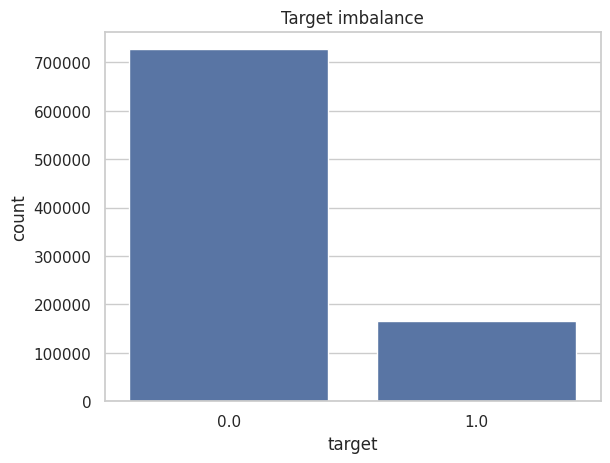

In [9]:
target = 'target'
print(train[target].value_counts(normalize=True))
sns.countplot(x=target, data=train)
plt.title('Target imbalance')
plt.show()

In [10]:
def missing_summary(df):
    miss = df.isna().sum()
    return pd.DataFrame({
        'missing': miss,
        'pct'   : miss / len(df) * 100
    }).query('missing>0').sort_values('pct', ascending=False)

print('TRAIN missing')
display(missing_summary(train))
print('TEST missing')
display(missing_summary(test))

TRAIN missing


,missing,pct
feature_4,396883,44.415037
feature_9,232430,26.011160
feature_5,175834,19.677521
feature_6,108046,12.091390
feature_7,93655,10.480898
feature_1,83574,9.352737
feature_8,79259,8.869847
feature_2,55999,6.266828
feature_3,27828,3.114222
feature_10,16801,1.880194


TEST missing


,missing,pct
feature_4,134494,45.153428
feature_9,89773,30.139327
feature_5,65267,21.911972
feature_7,61291,20.577117
feature_6,35043,11.764923
feature_8,33124,11.120661
feature_1,28924,9.710602
feature_2,19240,6.459410
feature_3,17295,5.806419
feature_10,12575,4.221782


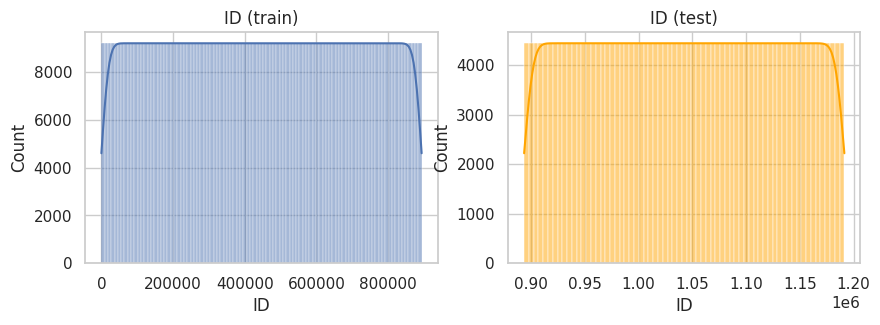

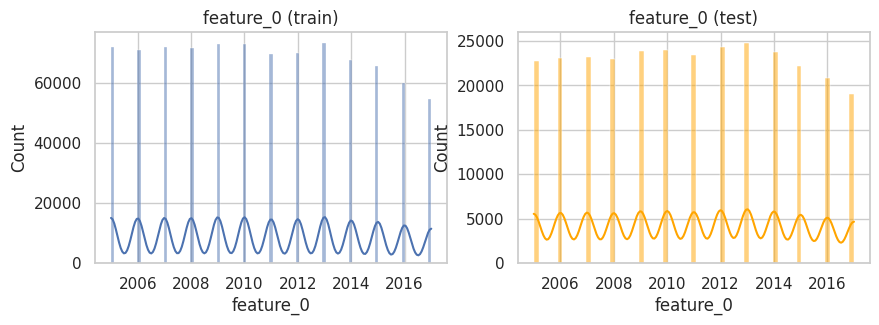

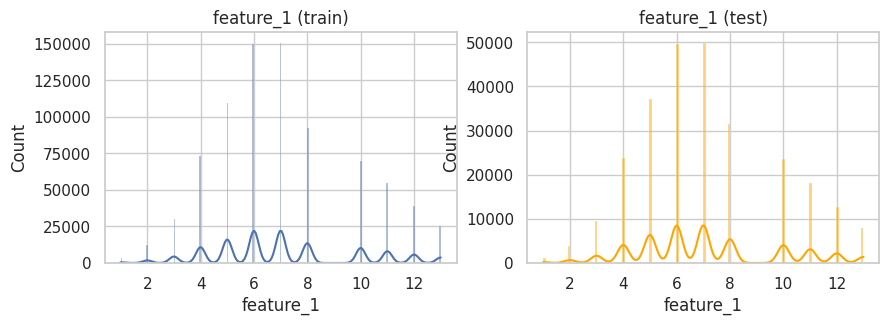

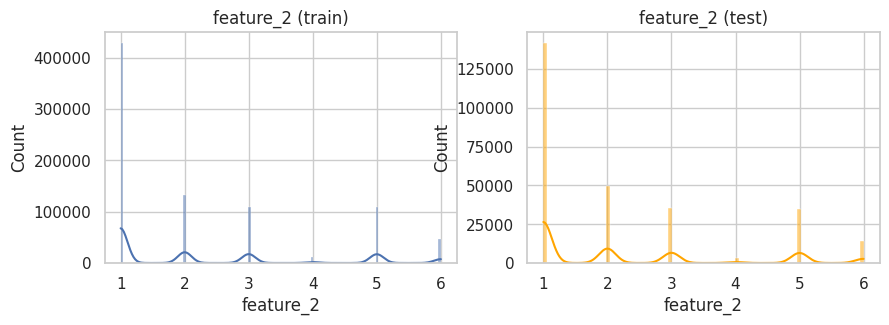

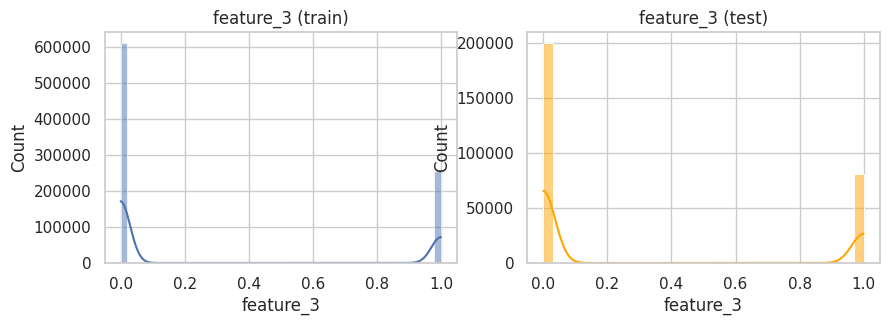

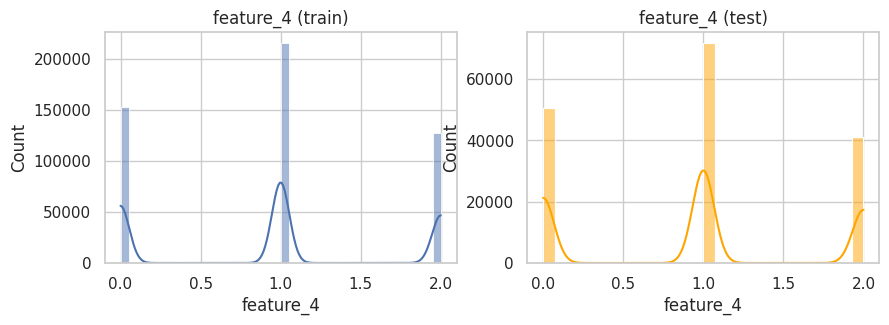

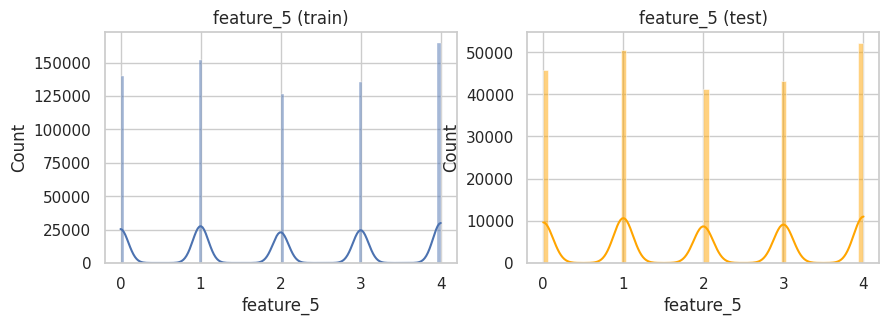

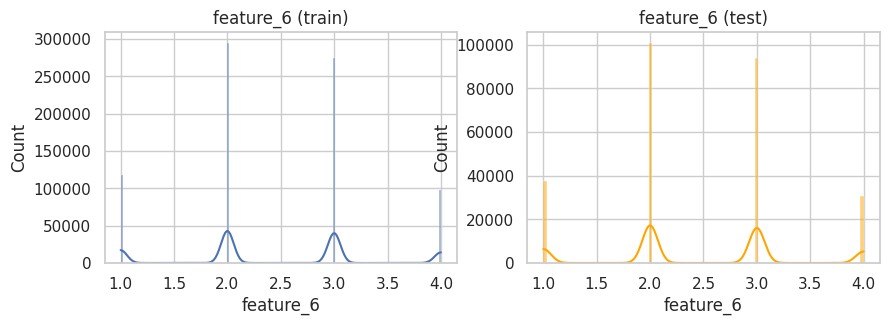

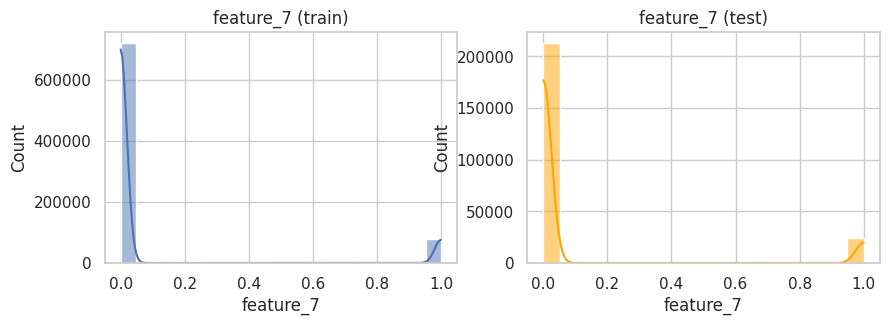

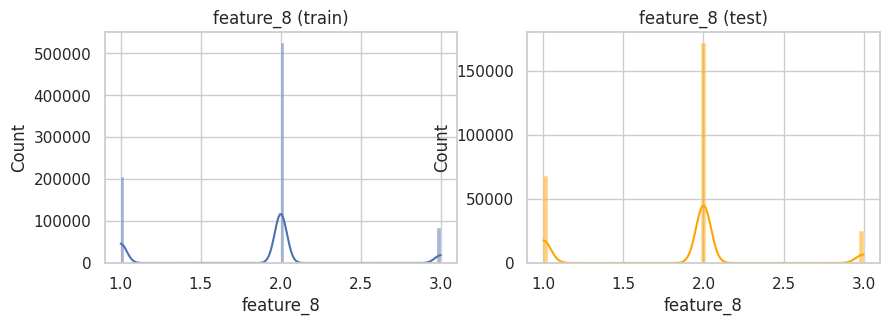

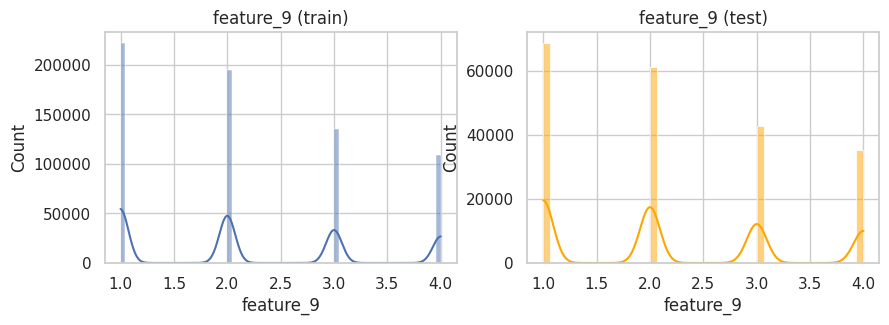

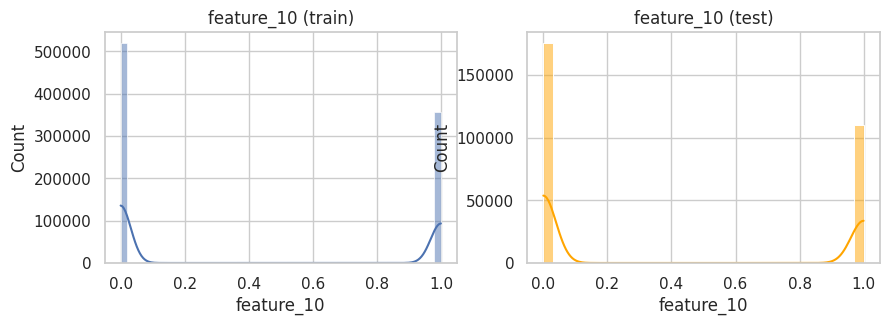

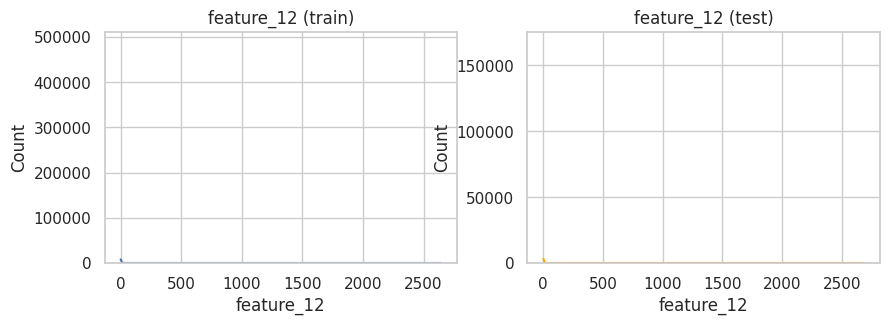

In [11]:
num_cols = [c for c in train.columns if train[c].dtype != 'object' and c not in ['example_id', target]]
cat_cols = [c for c in train.columns if c not in num_cols + ['example_id', target]]

for col in num_cols:
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    sns.histplot(train[col].dropna(), kde=True, ax=ax[0])
    ax[0].set_title(f'{col} (train)')
    sns.histplot(test[col].dropna(), kde=True, ax=ax[1], color='orange')
    ax[1].set_title(f'{col} (test)')
    plt.show()

In [12]:
for c in cat_cols:
    print(f'{c:12} train unique: {train[c].nunique():4} | test unique: {test[c].nunique():4}')

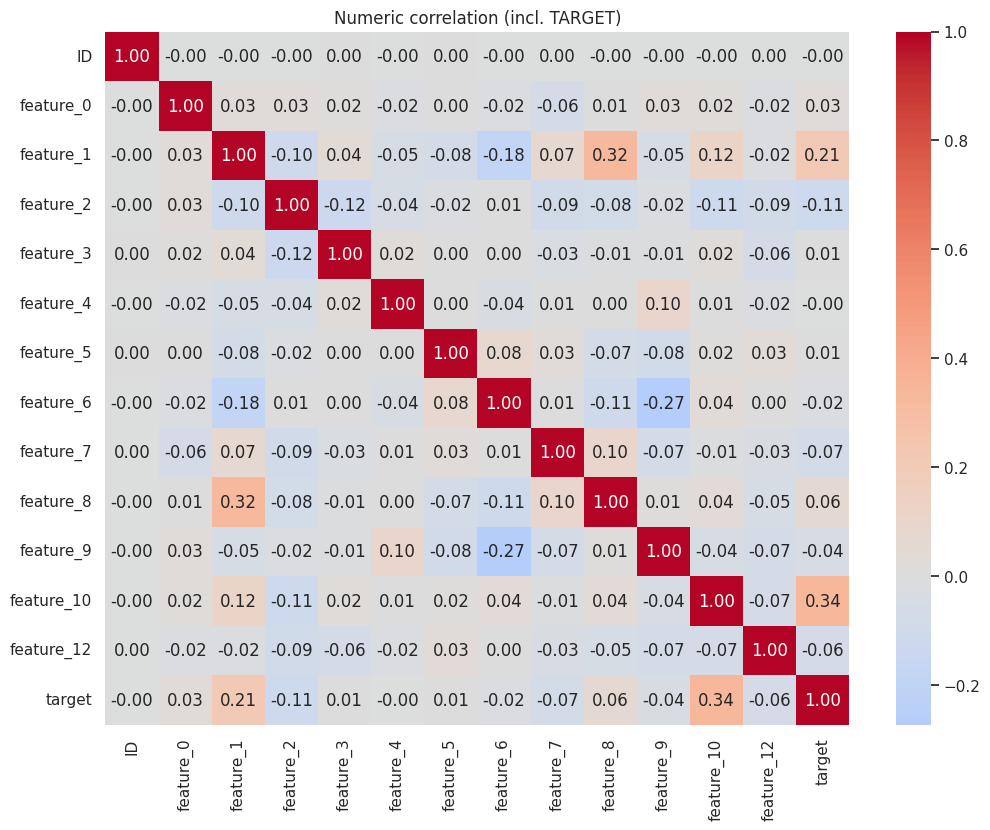

In [13]:
corr = train[num_cols + [target]].corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Numeric correlation (incl. TARGET)')
plt.show()

In [14]:
def engineer(df):
    df = df.copy()

    # 1. Missing flags
    for c in df.columns:
        if df[c].isna().any():
            df[f'{c}_na'] = df[c].isna().astype(int)

    # 2. Log-transform skewed numerics
    skew_cols = ['feature_3','feature_7']
    for c in skew_cols:
        df[f'{c}_log'] = np.log1p(df[c].fillna(0))

    # 3. Age-related interactions
    df['f2_x_f9'] = df['feature_2'] * df['feature_9']
    df['f2_div_f9'] = df['feature_2'] / (df['feature_9'] + 1)

    # 4. Binary interaction (feature_4 is binary)
    df['f4_x_f10'] = df['feature_4'] * df['feature_10']

    # 5. Ratio of two continuous
    df['f0_div_f8'] = df['feature_0'] / (df['feature_8'] + 1e-6)

    # 6. Binning ordinal / high-cardinality categorical
    if 'feature_5' in df.columns:   # ordinal hint
        df['f5_bin'] = pd.qcut(df['feature_5'], q=5, duplicates='drop', labels=False)

    # 7. Rare category grouping (threshold 1% of train)
    rare_thr = int(0.01 * len(df))
    for c in cat_cols:
        vc = df[c].value_counts()
        rare = vc[vc < rare_thr].index
        df[c] = df[c].where(~df[c].isin(rare), 'RARE')

    return df

train_eng = engineer(train)
test_eng  = engineer(test)

In [18]:
ID_COL = 'example_id'
TARGET = 'target'

feat_cols = [c for c in train_eng.columns if c not in [ID_COL, TARGET]]
print(f'Using {len(feat_cols)} features')

Using 31 features


In [19]:
num_cols_eng = [c for c in feat_cols if train_eng[c].dtype != 'object']
cat_cols_eng = [c for c in feat_cols if c not in num_cols_eng]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols_eng),
        ('cat', categorical_transformer, cat_cols_eng)
    ], remainder='passthrough')

In [25]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def lgb_cv(X, y, params, nfold=3, fast=False, seed=42):
    """
    Faster LightGBM cross-validation with early stopping and optional fast mode.
    """

    # If fast mode is enabled, adjust params automatically
    if fast:
        params = params.copy()
        params.update({
            'num_leaves': 16,
            'max_depth': 6,
            'feature_fraction': 0.7,
            'bagging_fraction': 0.7,
            'learning_rate': 0.08
        })
        nfold = 3

    skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=seed)
    oof_preds = np.zeros(len(X))
    scores = []
    models = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        print(f'\n=== Fold {fold+1}/{nfold} ===')

        model = lgb.train(
            params=params,
            train_set=dtrain,
            valid_sets=[dtrain, dvalid],
            valid_names=['train', 'valid'],
            num_boost_round=1000,  # was 5000 — early stopping will kick in earlier
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, first_metric_only=True),
                lgb.log_evaluation(period=100)  # less verbose for speed
            ]
        )

        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        auc = roc_auc_score(y_val, oof_preds[val_idx])
        scores.append(auc)
        models.append(model)
        print(f'Fold {fold+1} AUC: {auc:.5f} | Best iteration: {model.best_iteration}')

    print(f'\nCV mean AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}')
    return models, oof_preds, scores


In [ ]:
pos_weight = (train[TARGET] == 0).sum() / (train[TARGET] == 1).sum()

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42,
    'scale_pos_weight': pos_weight,
    'n_jobs': -1,
    'device': 'cpu'  # 👈 Force CPU mode
}


X = pd.DataFrame(preprocessor.fit_transform(train_eng[feat_cols]))
y = pd.Series(train_eng[TARGET].values)

# Run in fast mode for quick iteration (3 folds, shallower trees, higher LR)
models, oof, cv_scores = lgb_cv(X, y, lgb_params, fast=True)



=== Fold 1/3 ===
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.86633	valid's auc: 0.866227
[200]	train's auc: 0.878862	valid's auc: 0.878767
[300]	train's auc: 0.885942	valid's auc: 0.885622
[400]	train's auc: 0.890114	valid's auc: 0.889514
[500]	train's auc: 0.893786	valid's auc: 0.892879
[600]	train's auc: 0.896782	valid's auc: 0.895452
[700]	train's auc: 0.899181	valid's auc: 0.89745
[800]	train's auc: 0.901169	valid's auc: 0.898941
[900]	train's auc: 0.902932	valid's auc: 0.900303
[1000]	train's auc: 0.904502	valid's auc: 0.901423
Did not meet early stopping. Best iteration is:
[999]	train's auc: 0.904498	valid's auc: 0.901426
Evaluated only: auc
Fold 1 AUC: 0.90143 | Best iteration: 999

=== Fold 2/3 ===
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.866956	valid's auc: 0.865959


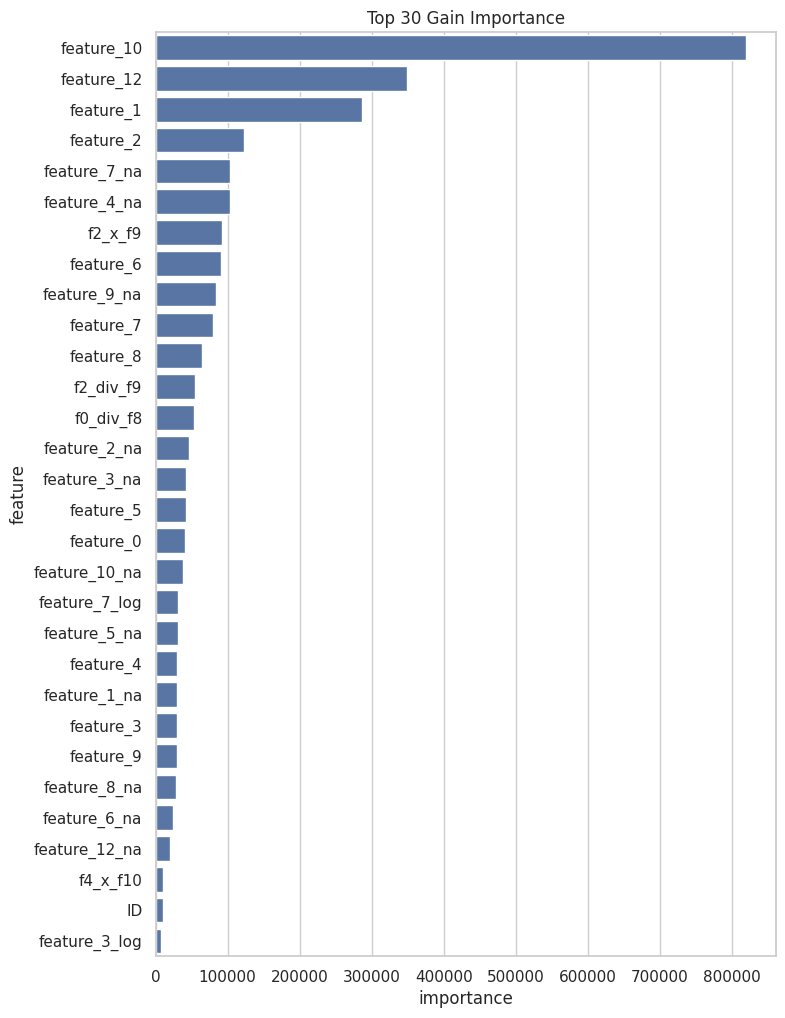

In [29]:
imp_df = pd.DataFrame({
    'feature': feat_cols,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in models], axis=0)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,12))
sns.barplot(x='importance', y='feature', data=imp_df.head(30))
plt.title('Top 30 Gain Importance')
plt.show()

In [30]:
X_test = preprocessor.transform(test_eng[feat_cols])
test_preds = np.mean([m.predict(X_test) for m in models], axis=0)

submission['TARGET'] = test_preds
submission.to_csv('submission.csv', index=False)
print('submission.csv saved!')
submission.head()

submission.csv saved!


,ID,target,TARGET
0,893579,0,0.147539
1,893580,0,0.894101
2,893581,0,0.008301
3,893582,0,0.308404
4,893583,0,0.542346


In [34]:
submission = submission[['ID', 'target']]  # keep only the required columns
submission.to_csv('submission.csv', index=False)

